In [7]:
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.spatial import KDTree

pose_file = "/workspace/localization_ws/pose.txt"

def load_lidar_poses(pose_file):
    """加载激光雷达位姿文件"""
    poses = []
    timestamps = []
    with open(pose_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            if len(data) < 8:
                continue
            timestamp = float(data[0])
            position = np.array([float(data[1]), float(data[2]), float(data[3])])
            quaternion = np.array([float(data[4]), float(data[5]), float(data[6]), float(data[7])])  # qx, qy, qz, qw
            
            # 转换为旋转矩阵
            rotation = Rotation.from_quat([quaternion[0], quaternion[1], quaternion[2], quaternion[3]])
            rot_mat = rotation.as_matrix()
            
            poses.append({
                'timestamp': timestamp,
                'position': position,
                'rotation': rot_mat
            })
            timestamps.append(timestamp)
    
    return poses, np.array(timestamps)

load_lidar_poses(pose_file)

calib_file = "/workspace/localization_ws/calibration.json"
def load_calibration(calib_file):
    """加载外参配置文件"""
    with open(calib_file, 'r') as f:
        calib = json.load(f)
    
    # 提取左右相机的外参
    cameras = {}
    for cam in calib['cameras']:
        name = cam['name']
        rot_l2s = np.array(cam['transform_from_lidar']['rotation'])
        t_l2s = np.array(cam['transform_from_lidar']['position'])
        
        # 计算传感器在雷达坐标系中的位置和姿态
        rot_s2l = rot_l2s.T
        t_s2l = -rot_l2s.T @ t_l2s
        
        cameras[name] = {
            'rot_s2l': rot_s2l,  # 传感器到雷达的旋转
            't_s2l': t_s2l,      # 传感器到雷达的平移
            'rot_l2s': rot_l2s,  # 雷达到传感器的旋转
            't_l2s': t_l2s       # 雷达到传感器的平移
        }
    
    return cameras
load_calibration(calib_file)

def find_nearest_pose(timestamp, lidar_poses, lidar_timestamps):
    """找到时间戳最接近的激光位姿"""
    # 使用KDTree进行最近邻搜索
    tree = KDTree(lidar_timestamps.reshape(-1, 1))
    dist, idx = tree.query([[timestamp]])
    return lidar_poses[int(idx)]


left_dir = "/workspace/catkin_ws/left"
right_dir = "/workspace/catkin_ws/right"
def get_image_timestamps(image_dir):
    """获取图像文件夹中的所有时间戳"""
    timestamps = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            # 假设文件名为"timestamp.jpg"
            timestamp_sec = float(filename.split('.')[0].split('_')[0])
            timestamp = timestamp_sec + float(filename.split('.')[0].split('_')[1]) / 1e9
            timestamps.append(timestamp)
    return sorted(timestamps)

get_image_timestamps(left_dir)
get_image_timestamps(right_dir)

def transform_pose(lidar_to_world, cam_to_lidar):
    """计算世界坐标系到相机坐标系的变换"""
    # 构建齐次变换矩阵
    T_world_lidar = np.eye(4)
    T_world_lidar[:3, :3] = lidar_to_world['rotation']
    T_world_lidar[:3, 3] = lidar_to_world['position']
    
    T_lidar_cam = np.eye(4)
    T_lidar_cam[:3, :3] = cam_to_lidar['rot_s2l']
    T_lidar_cam[:3, 3] = cam_to_lidar['t_s2l']
    
    # 计算世界到相机的变换
    T_world_cam = T_world_lidar @ T_lidar_cam
    
    # 提取位置和旋转
    position = T_world_cam[:3, 3]
    rotation_mat = T_world_cam[:3, :3]
    
    # 转换为四元数 (x, y, z, w)
    rotation = Rotation.from_matrix(rotation_mat)
    quaternion = rotation.as_quat()  # [x, y, z, w]
    
    return position, quaternion

def save_camera_poses(output_file, poses):
    """保存相机位姿到文件"""
    with open(output_file, 'w') as f:
        for pose in poses:
            ts = pose['timestamp']
            p = pose['position']
            q = pose['quaternion']  # [qx, qy, qz, qw]
            f.write(f"{ts:.6f} {p[0]:.6f} {p[1]:.6f} {p[2]:.6f} "
                    f"{q[0]:.6f} {q[1]:.6f} {q[2]:.6f} {q[3]:.6f}\n")

# 配置文件路径

lidar_pose_file = "/workspace/localization_ws/pose.txt"
calib_file = "/workspace/localization_ws/calibration.json"
left_image_dir = "/workspace/catkin_ws/left"
right_image_dir = "/workspace/catkin_ws/right"
    
# 加载数据
lidar_poses, lidar_timestamps = load_lidar_poses(lidar_pose_file)
cameras = load_calibration(calib_file)
    
# 处理左相机
left_timestamps = get_image_timestamps(left_image_dir)
left_poses = []
for ts in left_timestamps:
    nearest_lidar_pose = find_nearest_pose(ts, lidar_poses, lidar_timestamps)
    position, quaternion = transform_pose(nearest_lidar_pose, cameras['left'])
    left_poses.append({
        'timestamp': ts,
        'position': position,
        'quaternion': quaternion
    })
save_camera_poses('left_pose.txt', left_poses)
    
# 处理右相机
right_timestamps = get_image_timestamps(right_image_dir)
right_poses = []
for ts in right_timestamps:
    nearest_lidar_pose = find_nearest_pose(ts, lidar_poses, lidar_timestamps)
    position, quaternion = transform_pose(nearest_lidar_pose, cameras['right'])
    right_poses.append({
        'timestamp': ts,
        'position': position,
        'quaternion': quaternion
    })
save_camera_poses('right_pose.txt', right_poses)
    
print(f"处理完成: 左相机位姿保存到 left_pose.txt ({len(left_poses)}个)")
print(f"处理完成: 右相机位姿保存到 right_pose.txt ({len(right_poses)}个)")


/tmp/ipykernel_80738/876475972.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return lidar_poses[int(idx)]


处理完成: 左相机位姿保存到 left_pose.txt (1809个)
处理完成: 右相机位姿保存到 right_pose.txt (1809个)


In [4]:
import numpy as np
import rerun as rr
from scipy.spatial.transform import Rotation

def load_poses(pose_file):
    """加载位姿文件"""
    timestamps = []
    positions = []
    quaternions = []
    
    with open(pose_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            if len(data) < 8:
                continue
                
            timestamps.append(float(data[0]))
            positions.append([float(data[1]), float(data[2]), float(data[3])])
            quaternions.append([float(data[4]), float(data[5]), float(data[6]), float(data[7])])
    
    return np.array(timestamps), np.array(positions), np.array(quaternions)

def visualize_poses(lidar_ts, lidar_pos, lidar_quat, 
                   left_ts, left_pos, left_quat, 
                   right_ts, right_pos, right_quat):
    """使用Rerun可视化位姿"""
    
    # 初始化Rerun
    rr.init("sensor_poses", spawn=True)
    
    # 设置坐标系方向
    rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)
    
    # 创建时间线
    rr.set_time_seconds("timestamp", 0)
    
    # 可视化激光雷达轨迹
    rr.log("world/lidar", rr.Points3D(lidar_pos, colors=[255, 0, 0]), timeless=True)
    rr.log("world/lidar/trajectory", rr.LineStrips3D([lidar_pos], colors=[200, 0, 0]), timeless=True)
    
    # 可视化左相机轨迹
    rr.log("world/left_camera", rr.Points3D(left_pos, colors=[0, 255, 0]), timeless=True)
    rr.log("world/left_camera/trajectory", rr.LineStrips3D([left_pos], colors=[0, 200, 0]), timeless=True)
    
    # 可视化右相机轨迹
    rr.log("world/right_camera", rr.Points3D(right_pos, colors=[0, 0, 255]), timeless=True)
    rr.log("world/right_camera/trajectory", rr.LineStrips3D([right_pos], colors=[0, 0, 200]), timeless=True)
    
    # 创建坐标系可视化
    def log_coordinate_frame(path, position, quaternion, color, length=0.5):
        """记录坐标系"""
        # 创建坐标系箭头
        rotation = Rotation.from_quat(quaternion)
        x_axis = rotation.apply([length, 0, 0])
        y_axis = rotation.apply([0, length, 0])
        z_axis = rotation.apply([0, 0, length])
        
        # 记录坐标轴
        rr.log(
            f"{path}/axes",
            rr.Arrows3D(
                origins=[position, position, position],
                vectors=[x_axis, y_axis, z_axis],
                colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]]
            )
        )
    
    # 记录所有时间点的位姿
    all_ts = np.concatenate([lidar_ts, left_ts, right_ts])
    all_ts.sort()
    
    index = 1
    for ts in all_ts:
        if index > 10:
            break
        index += 1
        rr.set_time_seconds("timestamp", ts)
        
        # 找到最接近的激光雷达位姿
        lidar_idx = np.abs(lidar_ts - ts).argmin()
        lidar_position = lidar_pos[lidar_idx]
        lidar_quaternion = lidar_quat[lidar_idx]
        
        # 找到最接近的左相机位姿
        left_idx = np.abs(left_ts - ts).argmin()
        left_position = left_pos[left_idx]
        left_quaternion = left_quat[left_idx]
        
        # 找到最接近的右相机位姿
        right_idx = np.abs(right_ts - ts).argmin()
        right_position = right_pos[right_idx]
        right_quaternion = right_quat[right_idx]
        
        # 记录当前位姿
        rr.log("world/lidar/current", rr.Transform3D(
            translation=lidar_position,
            rotation=rr.Quaternion(xyzw=lidar_quaternion)
        ))
        
        rr.log("world/left_camera/current", rr.Transform3D(
            translation=left_position,
            rotation=rr.Quaternion(xyzw=left_quaternion)
        ))
        
        rr.log("world/right_camera/current", rr.Transform3D(
            translation=right_position,
            rotation=rr.Quaternion(xyzw=right_quaternion)
        ))
        
        # 记录坐标系
        log_coordinate_frame("world/lidar/current", lidar_position, lidar_quaternion, [255, 100, 100])
        log_coordinate_frame("world/left_camera/current", left_position, left_quaternion, [100, 255, 100])
        log_coordinate_frame("world/right_camera/current", right_position, right_quaternion, [100, 100, 255])
    
    print("可视化完成！请在Rerun应用中查看结果")

def main():
    # 加载位姿数据
    lidar_ts, lidar_pos, lidar_quat = load_poses("pose.txt")
    left_ts, left_pos, left_quat = load_poses("left_pose.txt")
    right_ts, right_pos, right_quat = load_poses("right_pose.txt")
    
    # 可视化位姿
    visualize_poses(
        lidar_ts, lidar_pos, lidar_quat,
        left_ts, left_pos, left_quat,
        right_ts, right_pos, right_quat
    )

if __name__ == "__main__":
    main()

可视化完成！请在Rerun应用中查看结果


[2025-08-10T14:25:13Z ERROR re_grpc_client::message_proxy::write] Failed to gracefully shut down message proxy client: channel closed
/tmp/ipykernel_80738/4065445008.py:32: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)
/tmp/ipykernel_80738/4065445008.py:35: DeprecationWarning: Use `set_time(timestamp=seconds)` or `set_time(duration=seconds)` instead.
    See: https://www.rerun.io/docs/reference/migration/migration-0-23 for more details.
  rr.set_time_seconds("timestamp", 0)
/tmp/ipykernel_80738/4065445008.py:38: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr.log("world/lidar", rr.Points3D(lidar_pos, colors=[255, 0, 0]), timeless=True)
/tmp/ipykernel_80738/4065445008.py:39: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr.log("world/lidar/trajectory", rr.LineStrips3D([lidar_pos], colors=[200, 0, 0]), timele

In [10]:
import numpy as np
lidar_pose = lidar_poses[0]
lidar_pose['position'] = np.array([0.0, 0.0, 0.0])
lidar_pose['rotation'] = np.eye(3)  # 单位矩阵表示无旋转

lidar_p = lidar_pose['position']
lidar_q = Rotation.from_matrix(lidar_pose['rotation']).as_quat()  # 转换为四元数

left_pos,left_q =  transform_pose(lidar_pose, cameras['left'])
right_pos,right_q = transform_pose(lidar_pose, cameras['right'])

lidar_timestamps = [0.0]
left_timestamps = [0.0]
right_timestamps = [0.0]

lidar_p = [lidar_p]
lidar_q = [lidar_q]
left_p = [left_pos]
left_q = [left_q]
right_q = [right_q]
right_p = [right_pos]

import rerun as rr

rr.init("sensor_poses", spawn=True)
visualize_poses(
    lidar_timestamps, lidar_p,lidar_q,
    left_timestamps, left_p,left_q,
    right_timestamps,right_p,right_q 
)



可视化完成！请在Rerun应用中查看结果


/tmp/ipykernel_80738/4065445008.py:32: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)
/tmp/ipykernel_80738/4065445008.py:35: DeprecationWarning: Use `set_time(timestamp=seconds)` or `set_time(duration=seconds)` instead.
    See: https://www.rerun.io/docs/reference/migration/migration-0-23 for more details.
  rr.set_time_seconds("timestamp", 0)
/tmp/ipykernel_80738/4065445008.py:38: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr.log("world/lidar", rr.Points3D(lidar_pos, colors=[255, 0, 0]), timeless=True)
/tmp/ipykernel_80738/4065445008.py:39: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr.log("world/lidar/trajectory", rr.LineStrips3D([lidar_pos], colors=[200, 0, 0]), timeless=True)
/tmp/ipykernel_80738/4065445008.py:42: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'timeless')
  rr

/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_80738/3401540102.py:127: UserWarning: Glyph 26631 (\N{CJK UNIFIED I

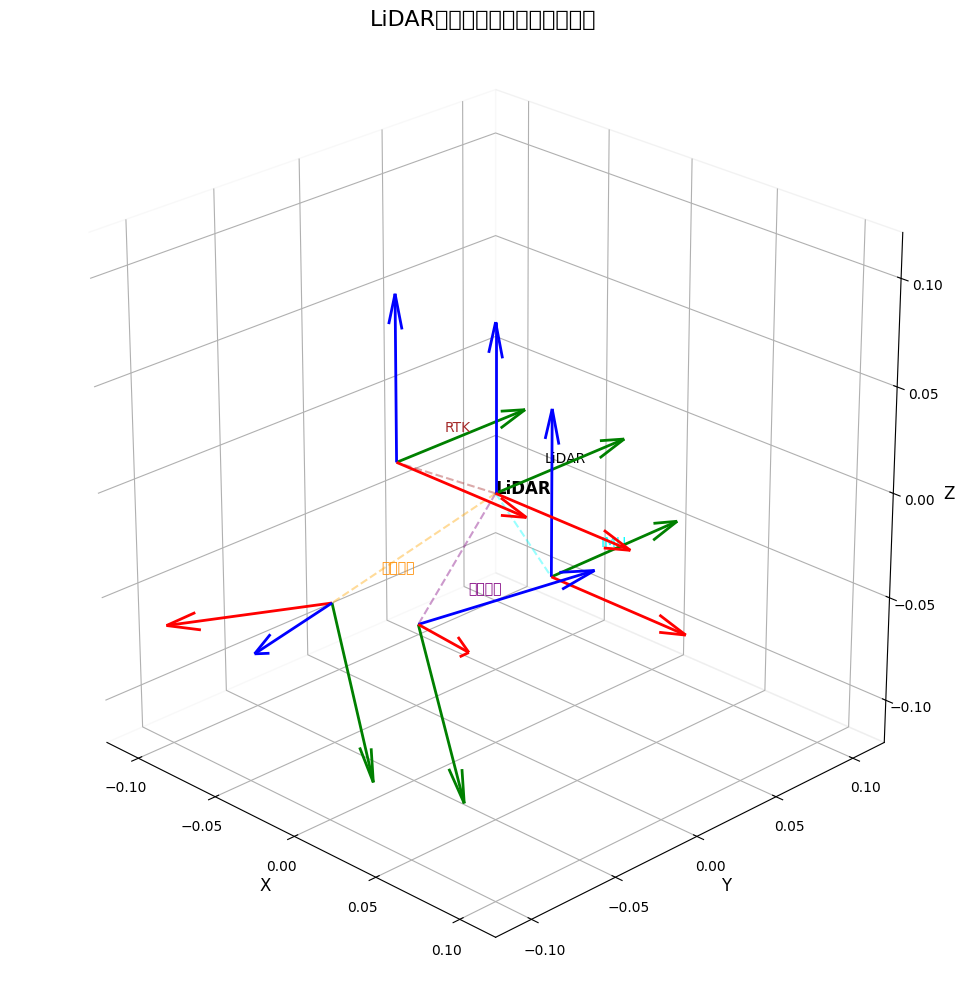

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_coordinate_frame(ax, origin, rotation_matrix, label, color, size=0.1):
    """绘制三维坐标系"""
    origin = np.array(origin)
    rotation = np.array(rotation_matrix).T  # 矩阵转置以正确表示旋转关系
    
    # 创建坐标轴端点
    x_axis = origin + rotation[:, 0] * size
    y_axis = origin + rotation[:, 1] * size
    z_axis = origin + rotation[:, 2] * size
    
    # 绘制坐标轴
    ax.quiver(*origin, *(x_axis - origin), color='r', arrow_length_ratio=0.2, linewidth=2)
    ax.quiver(*origin, *(y_axis - origin), color='g', arrow_length_ratio=0.2, linewidth=2)
    ax.quiver(*origin, *(z_axis - origin), color='b', arrow_length_ratio=0.2, linewidth=2)
    
    # 添加标签
    ax.text(*origin, label, color=color, fontsize=12, weight='bold')

# 创建3D图形
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('LiDAR及各传感器坐标系相对关系', fontsize=16)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)

# 添加网格和视角设置
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(True, alpha=0.3)
ax.view_init(elev=25, azim=-45)
ax.set_box_aspect([1, 1, 1])  # 保证等比例轴

# 自定义坐标系绘制参数
frame_size = 0.08
label_offset = 0.015

# --- LiDAR 坐标系 (原点) ---
lidar_origin = [0, 0, 0]
lidar_rotation = np.eye(3)
plot_coordinate_frame(ax, lidar_origin, lidar_rotation, "LiDAR", "black", frame_size)
ax.text(*(np.array(lidar_origin) + label_offset), "LiDAR", color='black', fontsize=10)

# --- 左摄像头坐标系 ---
left_cam = {
    "position": [0.022938569673052866, -0.06896550684266556, -0.03052845480330616],
    "rotation": [
        [0.839230415032483, -0.4557123445176312, 0.29667923678385477],
        [0.33552854064055204, 0.004626544394827653, -0.9420186800178564],
        [0.42791694159033744, 0.8901150791561767, 0.15678723468052266]
    ]
}
plot_coordinate_frame(ax, left_cam["position"], left_cam["rotation"], "", "purple", frame_size)
ax.text(*(np.array(left_cam["position"]) + label_offset), "左摄像头", color='purple', fontsize=10)

# --- 右摄像头坐标系 ---
right_cam = {
    "position": [-0.017622902147289565, -0.08058152822131787, -0.030567946018988712],
    "rotation": [
        [-0.8610308345574257, -0.4179590276369971, -0.2897173677190908],
        [0.3300768435227371, -0.02591042843372049, -0.9435983928920435],
        [0.38687876565070034, -0.9080963059693156, 0.1602682743822792]
    ]
}
plot_coordinate_frame(ax, right_cam["position"], right_cam["rotation"], "", "orange", frame_size)
ax.text(*(np.array(right_cam["position"]) + label_offset), "右摄像头", color='darkorange', fontsize=10)

# --- IMU 坐标系 ---
imu = {
    "position": [0.011, 0.02329, -0.04412],
    "rotation": [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
}
plot_coordinate_frame(ax, imu["position"], imu["rotation"], "", "cyan", frame_size)
ax.text(*(np.array(imu["position"]) + label_offset), "IMU", color='cyan', fontsize=10)

# --- RTK 坐标系 ---
rtk = {
    "position": [-0.06134, 0, -0.00523],
    "rotation": [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
}
plot_coordinate_frame(ax, rtk["position"], rtk["rotation"], "", "brown", frame_size)
ax.text(*(np.array(rtk["position"]) + label_offset), "RTK", color='brown', fontsize=10)

# --- 连接线可视化相对位置关系 ---
sensor_positions = {
    "LiDAR": lidar_origin,
    "Left": left_cam["position"],
    "Right": right_cam["position"],
    "IMU": imu["position"],
    "RTK": rtk["position"]
}

# 添加从LiDAR到各传感器的连接线
sensor_colors = {"Left": "purple", "Right": "orange", "IMU": "cyan", "RTK": "brown"}
for name, color in sensor_colors.items():
    ax.plot([lidar_origin[0], sensor_positions[name][0]],
            [lidar_origin[1], sensor_positions[name][1]],
            [lidar_origin[2], sensor_positions[name][2]],
            '--', color=color, alpha=0.4)

# 设置坐标轴范围和图例位置
max_range = max(
    max(map(abs, coord)) 
    for sensor in [lidar_origin, left_cam["position"], right_cam["position"], 
                   imu["position"], rtk["position"]] 
    for coord in zip(*[sensor])
) * 1.5

ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(-max_range, max_range)

plt.tight_layout()
plt.show()